# Collaboration and Competition

---

Congratulations for completing the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program!  In this notebook, you will learn how to control agents in a more challenging environment, where the goal is to train a team of agents to play soccer.  **Note that this exercise is optional!**

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, 'scripts/')  # TODO: insert at 1, 0 is the script path (or '' in REPL)

from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import shutil
import pprint 
import matplotlib.pyplot as plt
%matplotlib inline

from ppo_agent import PPO_Agent
from params import Params
from logger import Logger
from logger_team import Logger_Team
from CustomSummaryWriter import CustomSummaryWriter

In [3]:
# Time related Utilities
from datetime import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Asia/Singapore"))   # Set to your own timezone: pytz.all_timezones
    return pst_now.strftime(format)

def total_train_duration(start_time, end_time):
    duration = end_time - start_time              # For build-in functions
    duration_in_s = duration.total_seconds()      # Total number of seconds between dates
    days    = divmod(duration_in_s, 86400)        # Get days (without [0]!)
    hours   = divmod(days[1], 3600)               # Use remainder of days to calc hours
    minutes = divmod(hours[1], 60)                # Use remainder of hours to calc minutes
    seconds = divmod(minutes[1], 1)               # Use remainder of minutes to calc seconds
    print("TOTAL TRAINING DURATION: %d days, %d hours, %d minutes and %d seconds" % (days[0], hours[0], minutes[0], seconds[0]))

In [4]:
## For Debugging (Might slow progress quite alot!)
#torch.autograd.set_detect_anomaly(True)
#np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Soccer.app"`
- **Windows** (x86): `"path/to/Soccer_Windows_x86/Soccer.exe"`
- **Windows** (x86_64): `"path/to/Soccer_Windows_x86_64/Soccer.exe"`
- **Linux** (x86): `"path/to/Soccer_Linux/Soccer.x86"`
- **Linux** (x86_64): `"path/to/Soccer_Linux/Soccer.x86_64"`
- **Linux** (x86, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86"`
- **Linux** (x86_64, headless): `"path/to/Soccer_Linux_NoVis/Soccer.x86_64"`

For instance, if you are using a Mac, then you downloaded `Soccer.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Soccer.app")
```

In [4]:
env = UnityEnvironment(file_name='Soccer_Windows_x86_64/Soccer.exe')
#env = UnityEnvironment(file_name='Soccer_Windows_x86_64/Soccer.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we obtain separate brains for the striker and goalie agents.

In [5]:
# print the brain names
print(env.brain_names)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

['GoalieBrain', 'StrikerBrain']


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))

Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [8]:
# for i in range(2):                                         # play game for 2 episodes
#     env_info = env.reset(train_mode=False)                 # reset the environment    
#     g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
#     s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)
#     g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
#     s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
#     while True:
#         # select actions and send to environment
#         g_actions = np.random.randint(g_action_size, size=num_g_agents)
#         s_actions = np.random.randint(s_action_size, size=num_s_agents)
#         actions = dict(zip([g_brain_name, s_brain_name], 
#                            [g_actions, s_actions]))
#         env_info = env.step(actions)                       
        
#         # get next states
#         g_next_states = env_info[g_brain_name].vector_observations         
#         s_next_states = env_info[s_brain_name].vector_observations
        
#         # get reward and update scores
#         g_rewards = env_info[g_brain_name].rewards  
#         s_rewards = env_info[s_brain_name].rewards
#         g_scores += g_rewards
#         s_scores += s_rewards
        
#         # check if episode finished
#         done = np.any(env_info[g_brain_name].local_done)  
        
#         # roll over states to next time step
#         g_states = g_next_states
#         s_states = s_next_states
        
#         # exit loop if episode finished
#         if done:                                           
#             break
#     print('Scores from episode {}: {} (goalies), {} (strikers)'.format(i+1, g_scores, s_scores))

When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]

While training is taking place, statistics on agent performance are available from Tensorboard. To launch it use:
```python
cd <PROJECT_DIR>
tensorboard --logdir=runs
```

In [9]:
def ppo(params=Params(), g_logger=Logger(), s_logger=Logger(), team_logger=Logger_Team()):
    
    print ("***STARTED TRAINING AT {} \n".format(get_time('%Y-%m-%d--%H:%M:%S')))
    start_time  = datetime.now()         
    env_info = env.reset(train_mode=True)
    g_logger.initialize(g_agent, g_state_size, g_action_size)
    s_logger.initialize(s_agent, s_state_size, s_action_size)

#     try:
    start_eps = params.eps_to_resume_from if not params.restart_training else 1        
    for i_episode in range(start_eps, params.n_episodes+1):
        env_info = env.reset(train_mode=True)                  # reset the environment
        g_states = env_info[g_brain_name].vector_observations  # get initial state (goalies)
        s_states = env_info[s_brain_name].vector_observations  # get initial state (strikers)            
        g_scores = np.zeros(num_g_agents)                      # initialize the score (goalies)
        s_scores = np.zeros(num_s_agents)                      # initialize the score (strikers)
        num_steps = 0

        for t in range(params.max_t):    
            num_steps = t
            
            # REPORT NAN STATES
            if np.isnan(g_states).any() or np.isnan(s_states).any():
                print('\nNaN found in states. Skipping this episode.')
                break

            # Perform actions from each agent's policy network (clipped actions [0, -1])
            g_action, g_log_prob, g_entropy = g_agent.act(np.expand_dims(g_states[0], 0))
            s_action, s_log_prob, s_entropy = s_agent.act(np.expand_dims(s_states[0], 0))
            g_actions = (g_action, np.random.randint(g_action_size))
            s_actions = (s_action, np.random.randint(s_action_size))
            actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))         
            env_info = env.step(actions)                   

            # get next states, rewards & dones
            g_next_states = env_info[g_brain_name].vector_observations         
            s_next_states = env_info[s_brain_name].vector_observations
            g_rewards = env_info[g_brain_name].rewards  
            s_rewards = env_info[s_brain_name].rewards
            done = np.any(env_info[g_brain_name].local_done) 

            # REPORT NAN ACTIONS
            if np.isnan(g_actions).any() or np.isnan(s_actions).any():
                print('\nNaN found in actions. Skipping this episode.')
                break

            if np.isnan(g_rewards).any() or np.isnan(s_rewards).any():
                print("NaN Reward Found! Skipping this episode.")
                g_rewards = np.where(np.isnan(g_rewards), -5.0, g_rewards)
                s_rewards = np.where(np.isnan(s_rewards), -5.0, s_rewards)
                break

            # Store in experience buffer & learn
            all_states = np.concatenate((g_states[0], s_states[0], g_states[1], s_states[1]))            
            g_agent.step(g_states[0], all_states, g_actions[0], g_rewards[0], g_log_prob)
            s_agent.step(s_states[0], all_states, s_actions[0], s_rewards[0], s_log_prob)
            g_states = g_next_states
            s_states = s_next_states
            g_scores += g_rewards
            s_scores += s_rewards                

            # Break if game is over (time out / score)
            if done:   
                break 

        # Learn from episode
        g_agent.learn()
        s_agent.learn()
                
        # Print crucial results for progress tracking
        g_logger.log_stats(i_episode, g_scores[0], g_agent.actor_loss, g_agent.critic_loss)
        s_logger.log_stats(i_episode, s_scores[0], s_agent.actor_loss, s_agent.critic_loss)
        team_logger.log_stats(i_episode, g_scores[0] + s_scores[0], g_scores[1] + s_scores[1])
        print('\rEpisode {}: \tNum Steps: {} \t G_score: {:.2f} \t S_Score: {:.2f}  \tWin: {} \t\t'.format(i_episode, num_steps, g_logger.scores_deque[-1], 
                                                        s_logger.scores_deque[-1], team_logger.wins_deque[-1]), end="")

        if i_episode % params.save_every == 0:
            s_logger.save_weights(i_episode)
            g_logger.save_weights(i_episode)

        if i_episode % params.print_every == 0:
            print("""\rEpisode {}: \tTeam Score: {:.2f} \tOpponent Score: {:.2f} \t Win|Lose|Draw: {}|{}|{} \t [Out of {} Matches]"""
                  .format(i_episode, team_logger.scores_cum_deque[-1], team_logger.scores_opp_cum_deque[-1], np.count_nonzero(team_logger.wins_deque), 
                          np.count_nonzero(team_logger.lose_deque), np.count_nonzero(team_logger.draws_deque), len(team_logger.wins_deque)))

            if team_logger.scores_cum_deque[-1] >= params.target_score:
                print('\nEnvironment solved in {:d} episodes!\tAvg Total Score: {:.2f} \tAvg Total Wins: {}/{}'
                      .format(i_episode, np.mean(team_logger.scores_deque), np.count_nonzero(team_logger.wins_deque), len(team_logger.wins_deque)))
                if params.terminate_on_target_score:
                    break

    # Plot graphs & save final weights
    g_logger.save_weights(i_episode)
    s_logger.save_weights(i_episode)
    if params.plot_stats:
        team_logger.plot_stats()
        g_logger.plot_stats()                       
        s_logger.plot_stats()
    team_logger.log_overall_perf_tb()
    total_train_duration(start_time=start_time, end_time=datetime.now())
    print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
#     # Catch any exceptions (Esp with keyboard interrupts)
#     except BaseException as error:
#         print('\n\n==== An exception occurred: {}'.format(error))
#         g_logger.save_weights(i_episode)
#         s_logger.save_weights(i_episode)
#         if params.plot_stats:
#             g_logger.plot_stats()                       
#             s_logger.plot_stats()
#             team_logger.plot_stats()
#         team_logger.log_overall_perf_tb()
#         print ("***TRAINING STOPPED AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
    
    return s_logger.scores_list


=============== NETWORKS ===============
actor_net Actor(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
critic_net Critic(
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR_ACTOR:  8e-05
LR_CRITIC:  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
EPS:  0.1
EPS_DECAY:  1
WEIGHT_DECAY:  0


~~~~~~ TRAINING ~~~~~
***STARTED TRAINING AT 2022-03-29--11:25:09 

Episode 2: 	Team Score: -1.10 	Opponent Score: 1.10 	 Win|Lose|Draw: 0|1|1 	 [Out of 2 Matches]
Episode 4: 	Team Score: 0.00 	Opponent Score: -0.00 	 Win|Lose|Draw: 1|1|2 	 [Out of 4 Matches]
Epi

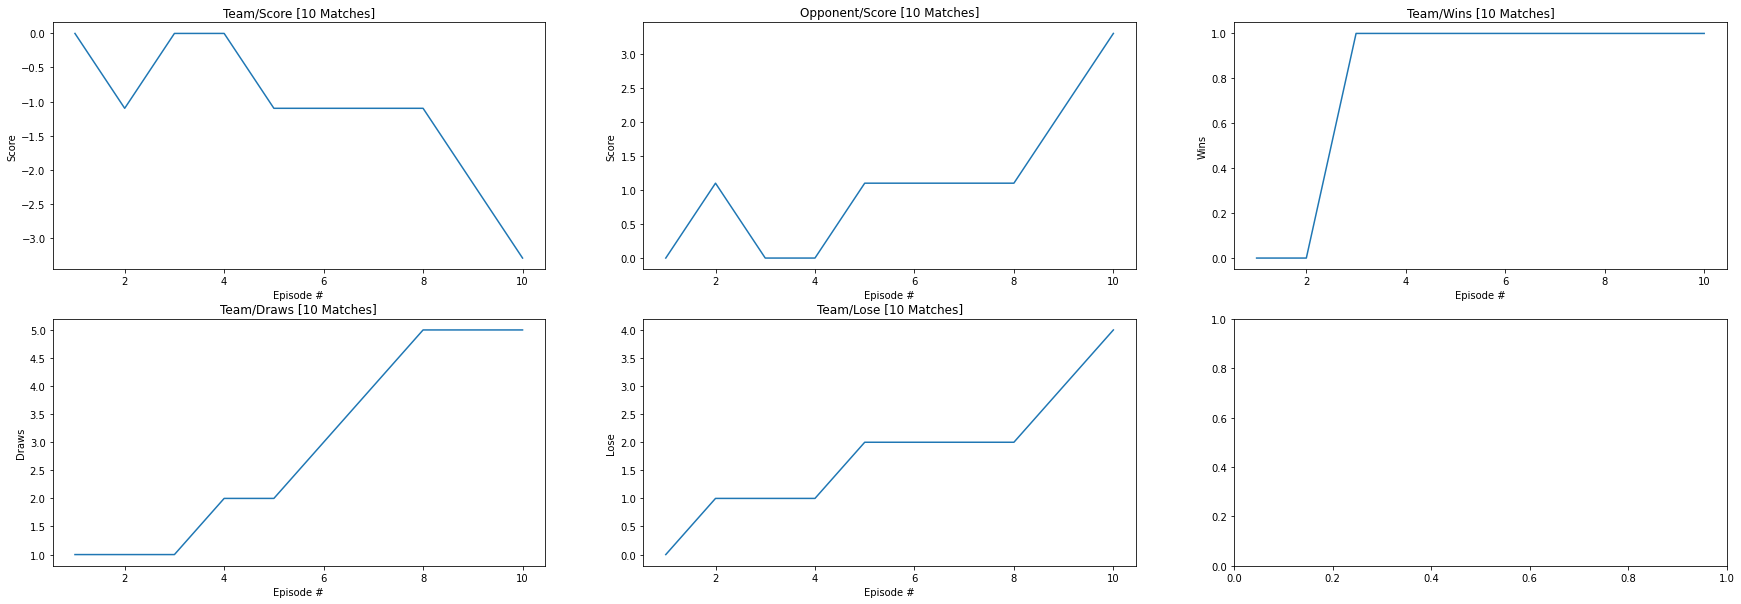

===== Goalie =====


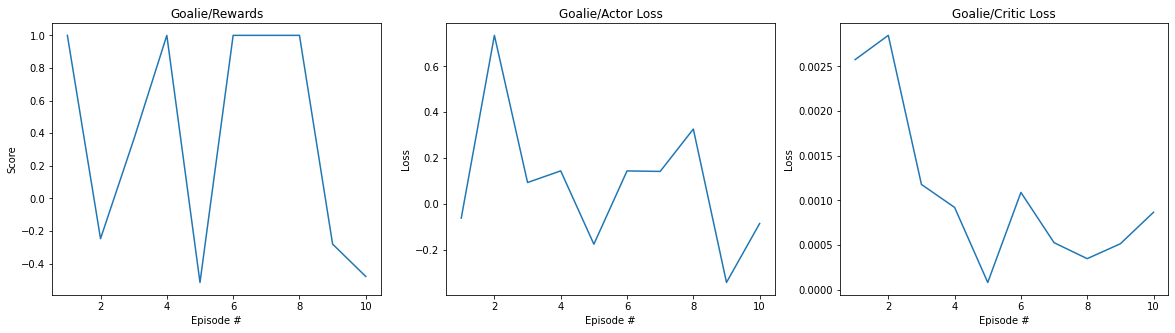

===== Striker =====


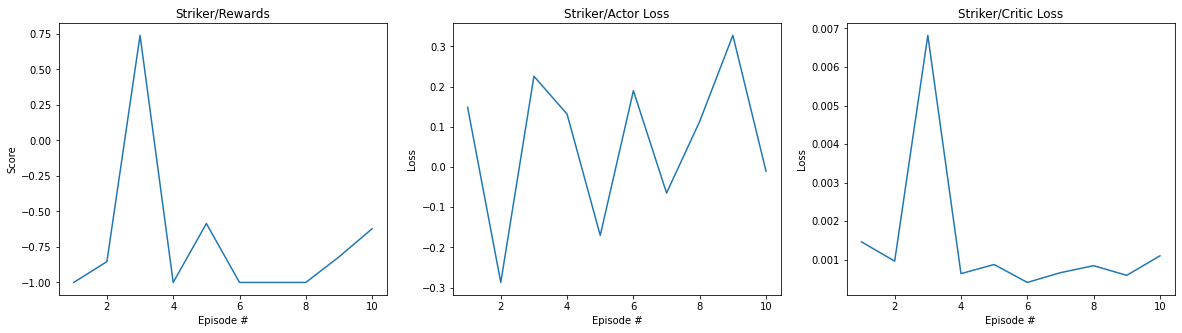

TOTAL TRAINING DURATION: 0 days, 0 hours, 0 minutes and 49 seconds
***TRAINING STOPPED AT 2022-03-29--11:25:58 


[-1.000000024214387,
 -0.8533333514351398,
 0.7400000549387187,
 -1.000000024214387,
 -0.5850000116042793,
 -1.000000024214387,
 -1.000000024214387,
 -1.000000024214387,
 -0.8200000098440796,
 -0.6216666791588068]

In [10]:
##################
# QUICK TEST
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=10
params.max_t = 600
params.print_every = 2
params.save_every = 10
params.log_weights_every = 10
params.terminate_on_target_score = True
#params.target_score = 1.1
params.plot_stats = True
params.lr_actor = 8e-5                 
params.lr_critic = 8e-5
params.batch_size = 32
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/test'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/test'



#### MAIN #####

# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g_logger = Logger(params, tb, "Goalie")
s_logger = Logger(params, tb, "Striker")
team_logger = Logger_Team(params, tb, "Team")
total_state_size = 2*g_state_size + 2*s_state_size

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=params)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=params)
g_agent.print_init_messages()
ppo(params, g_logger, s_logger, team_logger)

In [ ]:
##################
# Long Run...
##################

# Params Override: Initialized in params.py
params = Params()
params.verbose = True
params.random_seed = 1
params.n_episodes=10000
params.max_t = 600
params.print_every = 20
params.save_every = 20
params.log_weights_every = 20
params.terminate_on_target_score = True
params.target_score = 110.0
params.plot_stats = True
params.lr_actor = 8e-5                 
params.lr_critic = 8e-5
params.batch_size = 32
params.checkpoint_actor_weights_dir = 'weights/checkpoint_actor/expt_longer'
params.checkpoint_critic_weights_dir = 'weights/checkpoint_critic/expt_longer'


# Logging to the same Tensorboard instance
tb=CustomSummaryWriter()
g_logger = Logger(params, tb, "Goalie")
s_logger = Logger(params, tb, "Striker")
team_logger = Logger_Team(params, tb, "Team")
total_state_size = 2*g_state_size + 2*s_state_size

g_agent = PPO_Agent(g_state_size, total_state_size, g_action_size, params=params)
s_agent = PPO_Agent(s_state_size, total_state_size, s_action_size, params=params)
g_agent.print_init_messages()
ppo(params, g_logger, s_logger, team_logger)


=============== NETWORKS ===============
actor_net Actor(
  (fc1): Linear(in_features=336, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
critic_net Critic(
  (fc1): Linear(in_features=1344, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

=============== HYPERPARAMS ===============
DEVICE:  cuda:0
RANDOM SEED:  1
BATCH_SIZE:  32
HIDDEN_SIZES (ACTOR):  (256, 128)
HIDDEN_SIZES (CRITIC):  (256, 128)
LR_ACTOR:  8e-05
LR_CRITIC:  8e-05
GAMMA:  0.995
BETA:  0.001
BETA_DECAY:  0.995
EPS:  0.1
EPS_DECAY:  1
WEIGHT_DECAY:  0


~~~~~~ TRAINING ~~~~~
***STARTED TRAINING AT 2022-03-29--11:26:22 

Episode 20: 	Team Score: 5.50 	Opponent Score: -5.50 	 Win|Lose|Draw: 8|3|9 	 [Out of 20 Matches]
Episode 40: 	Team Score: 4.40 	Opponent Score: -4.40 	 Win|Lose|Draw: 13|9|18 	 [Out of 40 Matche